<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/DeepLearningAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ece472, Deep Learning – Assignment 1**
Submit by Sept. 9, 10pm

tldr: Perform linear regression of a noisy sinewave using a set of gaussian basis
functions with learned location and scale parameters. Model parameters are
learned with stochastic gradient descent. Use of automatic differentiation is
required. Hint: note your limits!

In [4]:
import numpy as np
import tensorflow as tf
import numpy.random as npr
import matplotlib.pyplot as plt

In [5]:
### parameters
N =50
sigma_noise = 0.1
M = 3
Nsteps = 10000
step_size  = 0.015
seed = 6

###Generating the Problem Scenario
#generating and plotting the original sinusoidal
npr.seed(seed)
x_rl = np.linspace(0,1,1000)
y_rl = np.sin(np.pi*2*x_rl)

#Noisy sinusoidal
x = npr.uniform(size = (N,1))
y = np.sin(np.pi*2*x) +npr.normal(size = (N,1) )*sigma_noise
y = y.reshape(-1)

### Functions
#initialize parameters
def initialize_params(M):  
  '''
  Initialize weights, means, standard of deviation, and b vectors according
  to the xavier normal initializer and return them in dicitonary params. 
  M - number of gaussians to use (and therefore also weights, mean, and sds)
  '''
  initializer = tf.keras.initializers.GlorotNormal(seed = seed)
  W = tf.Variable(initializer(shape=(1,M)), name = 'W')
  mu = tf.Variable(initializer(shape=(1,M)), name = 'mu')
  sig = tf.Variable(initializer(shape=(1,M)), name = 'sig')
  b =tf.Variable(initializer(shape=(1,1)), name = 'b')
  params = {'W': W,
           'mu': mu,
           'sig':sig,
           'b':b}
  return params


def predict(X,params):
  '''
  Predicts the corresponding y's for the input X (N,1) given M 
  gaussian curves with parameters from the params dict, and and offsett b 
  also from params
  '''
  gaussians = tf.math.exp(-tf.math.square(X-params['mu'])/
                          tf.math.square(params['sig']))
  y_hat = tf.reduce_sum(
      tf.multiply(gaussians,(params['W'])), axis = 1) + params['b']
  return y_hat

def loss(params, x,y):
  '''
  Determines the loss of the predicted value compared to the actual y value.
  Loss function is 0.5(y-y^)**2, but the half was ignored as it is a simple
  scaling factos
  '''
  y_hat = predict(x,params)
  lss = tf.math.reduce_mean((y-y_hat)**2)
  return lss

def step(params, x,y, step_size):
  '''
  A single step - predicting values, getting loss, & using the gradients of 
  loss to update the parameters
  '''
  with tf.GradientTape(persistent=True) as tape: 
    tape.watch(params)
    lss = loss(params, x,y)
  #get gradients
  grads = tape.gradient(lss, params)
  #return updated parameters
  return  {k:val-grads[k]*step_size for k,val in params.items()}


### Running the Experiment
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

params = initialize_params(M)
for _ in range(Nsteps):
  params = step(params,x_tf,y_tf, step_size)

x_exp = np.linspace(0,1, 1000)
W = params['W'].numpy()[0].reshape(1,-1)
b = params['b'].numpy()[0]
mu = params['mu'].numpy()[0].reshape(1,-1)
sig =params['sig'].numpy()[0].reshape(1,-1) 
y_hat = np.sum(W*np.exp(-(x_exp.reshape(-1,1) - mu)**2/
    (sig)**2),axis =1) + b

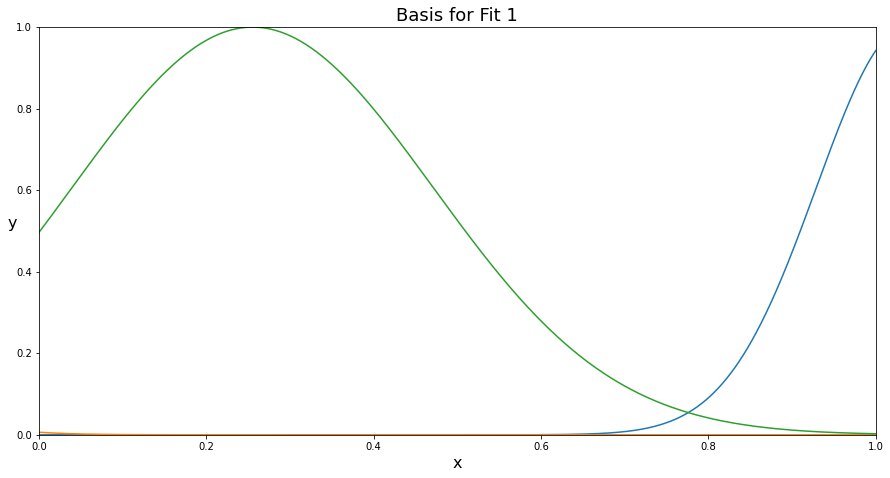

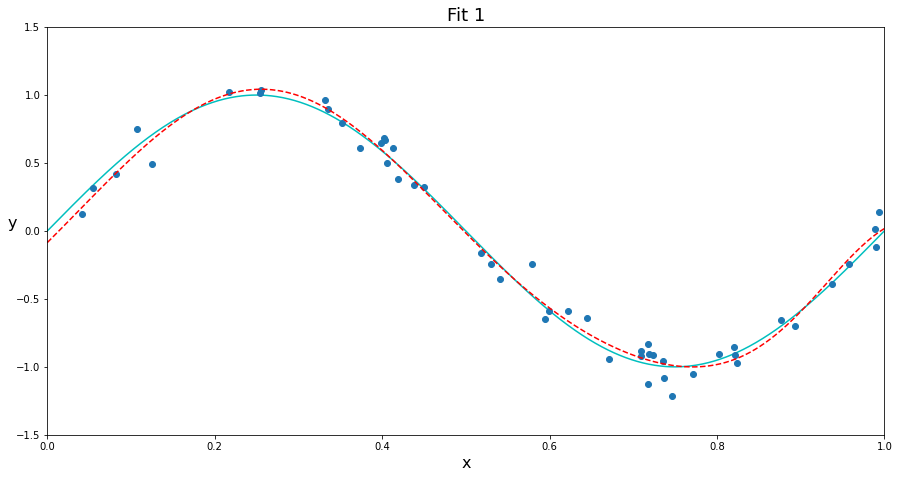

In [6]:
### Plots
#plotting Basis
plt.figure
plt.figure(figsize=(15,7.5))

for i in range(M):
  plt.plot(x_exp, np.exp(-(x_exp - params['mu'].numpy()[0][i])**2/
                           (params['sig'].numpy()[0][i])**2))
plt.xlabel('x', fontsize=16)
h = plt.ylabel('y', fontsize=16)
h.set_rotation(0)
plt.title('Basis for Fit 1', fontsize=18)

plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('Basis_of_Fit.eps', format='eps')
plt.show()

#plotting Fit
plt.figure
plt.figure(figsize=(15,7.5))

plt.plot(x_rl,y_rl,'c') #sine
plt.plot(x,y,'o') #sampled noisy sine
plt.plot(x_exp, y_hat, 'r--')

plt.xlabel('x', fontsize=16)
h = plt.ylabel('y', fontsize=16)
h.set_rotation(0)
plt.title('Fit 1', fontsize=18)

plt.xlim(0,1)
plt.ylim(-1.5,1.5)
plt.savefig('Fit.eps', format='eps')
plt.show()